# Exploratory Data Analysis for Cleaning=

Now that we have our main dataset. Let's start to explore the data. This will help us narrow down what we need to clean up, whether there any outliers, and general trends that we could be looking for.

In [45]:
#Start by importing drive from google.colab
from google.colab import drive
import os

#Mount the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
#Students Google Drive Path
toms_path = '/content/drive/MyDrive/Colab Notebooks/593 - Milestone I/593 - Insider Trading Milestone I Project'
kirts_path = None
ramis_path = None

#Navigate to the right working directory and confirm our current working drive
os.chdir(toms_path)
#os.chdir(kirts_path)
#os.chdir(ramis_path)
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/593 - Milestone I/593 - Insider Trading Milestone I Project


In [47]:
#Data import
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import timedelta, date, datetime

In [48]:
#Start by taking a quick look at the files in our directory so we can pull the right one
print(os.listdir())

['Thomas_EDA.ipynb', 'insider_transactions_readme[1].pdf', 'parse_form4.py', 'colab_requirements.txt', 'all_common_stock_purchases (6).csv', 'all_common_stock_purchases (6).gsheet', 'Mounting_Notebook_Importing_Form4.ipynb', 'Insider transaction data sets', 'Meeting Summaries', 'Insiders_multi_zip.ipynb', 'Insider Trading Proposal.docx', 'all_common_stock_purchases 2006 to 4Q24.csv', 'sec_insider_zips', 'Insiders_zip_data_processing.ipynb', 'stock_purchases_by_insider.csv', 'download_sec_zips.ipynb', 'common_stock_purchases_with_price_data.csv', 'stock_purchases_enhanced_with_company_info.csv', 'SPY_etf_benchmark_data.ipynb', 'yahoo_finance_price_data.ipynb', 'enhanced_common_stock_purchases_with_spy_data.csv', 'Market_Cap_Sector_Industry_Classification.ipynb', "Insider Trading: Do Corporate Insiders Know Something We Don't?.docx"]


In [49]:
#Read in the .csv file
cs_df = pd.read_csv('enhanced_common_stock_purchases_with_spy_data.csv')
print(f"Let's take a look at the size of our dataframe: {cs_df.shape}\n")
#print(cs_df.head())

#Let's take a look at the number of missing values in the file
missing_counts = cs_df.iloc[:,:20].isna().sum()
print(missing_counts)
missing_counts = cs_df.iloc[:,20:40].isna().sum()
print(missing_counts)
missing_counts = cs_df.iloc[:,40:].isna().sum()
print(missing_counts)

Let's take a look at the size of our dataframe: (122067, 64)

Insider Name                 0
Insider Title                0
Insider Role                 0
Issuer                       0
Ticker                       0
CIK Code                     0
Period of Report             0
Transaction Date             0
Security                     0
Transaction Code             0
Ownership Type               0
ACCESSION_NUMBER             0
shares                       0
price_per_share              0
shares_after                44
total_capital                0
average_price_per_share    539
price_-1month                0
trend_-1month                0
trend_transactiondate        0
dtype: int64
price_1month               4
trend_1month               4
price_2month             208
trend_2month             208
price_3month             828
trend_3month             828
price_4month            1132
trend_4month            1132
price_5month            1483
trend_5month            1483
price_6month   

The first thing we want to do is look for outliers or data that may not be accurate. The first thing that I notice is that there is a bunch of missing 'average price per shares'. Let's take a look at why and see if these need to be changed or removed.

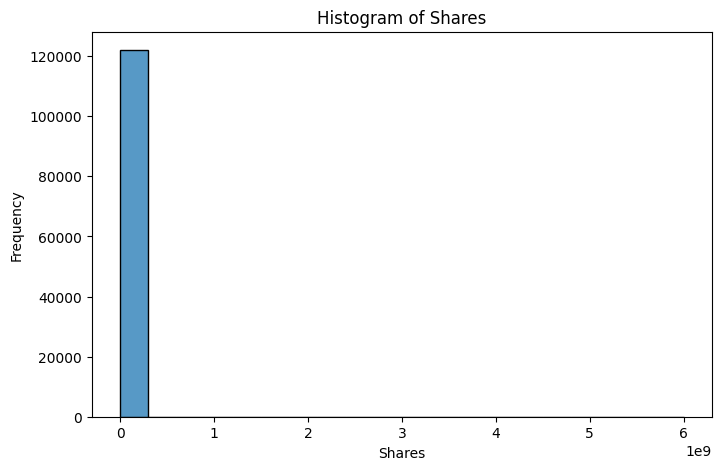

In [50]:
plt.figure(figsize = (8,5))
sns.histplot(data=cs_df, x='shares',bins=20)
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.title('Histogram of Shares')
plt.show()

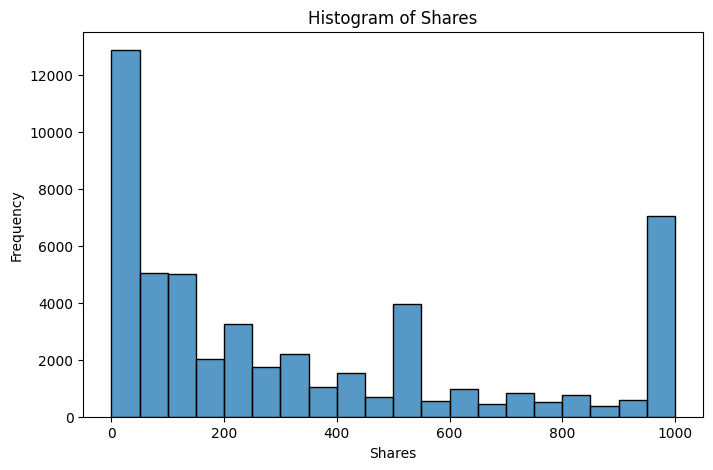

In [51]:
plt.figure(figsize=(8,5))
sns.histplot(data= cs_df, x = 'shares', bins=20, binrange=(0,1000))
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.title('Histogram of Shares')
plt.show()

In [52]:
temp_df = cs_df[cs_df['average_price_per_share'].isna()]
temp_df.iloc[:,:15].head()
#Looks like the shares are 0.0, let's make sure thats all of them
print(temp_df['shares'].unique())
#They are all 0.0 so let's drop all of those
cs_df = cs_df[~cs_df['average_price_per_share'].isna()]
missing_counts = cs_df.iloc[:,:20].isna().sum()
print(missing_counts)

[0.]
Insider Name                0
Insider Title               0
Insider Role                0
Issuer                      0
Ticker                      0
CIK Code                    0
Period of Report            0
Transaction Date            0
Security                    0
Transaction Code            0
Ownership Type              0
ACCESSION_NUMBER            0
shares                      0
price_per_share             0
shares_after               43
total_capital               0
average_price_per_share     0
price_-1month               0
trend_-1month               0
trend_transactiondate       0
dtype: int64


Okay, that cleaned up a bunch of data that we can't just impute. A think the next big issue will be the dates, so let's get some information about that. Let's start with the min date and max date to look and see if there were any outliers.

In [53]:
min_date = pd.to_datetime(cs_df['Transaction Date'], format = '%d-%b-%y').min()
max_date = pd.to_datetime(cs_df['Transaction Date'], format = '%d-%b-%y').max()
print(f"The min date is {min_date}")
print(f"The max date is {max_date}")

The min date is 1993-05-19 00:00:00
The max date is 2027-07-27 00:00:00


Okay, these are both way off. It may be easier to inspect these visually. Let's see if it would be a good idea to limit these transactions to between 01-01-2006 and 03-31-2025 (End of Q1).

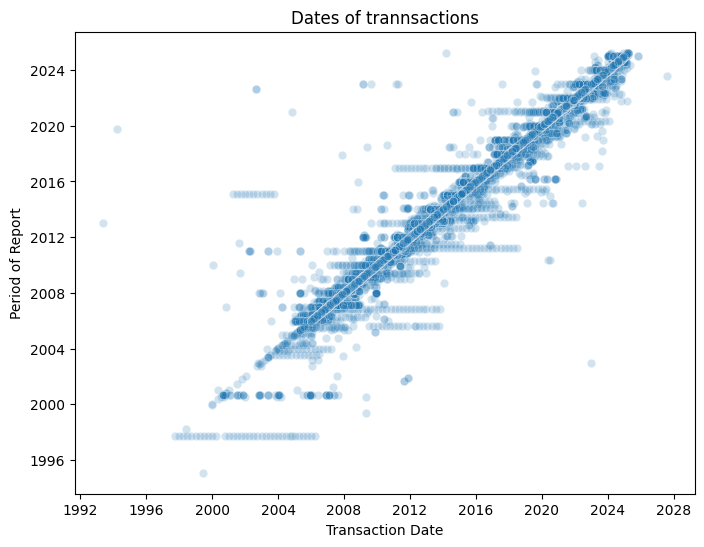

In [54]:
cs_df['Transaction Date'] = pd.to_datetime(cs_df['Transaction Date'],format='%d-%b-%y')
cs_df['Period of Report'] = pd.to_datetime(cs_df['Period of Report'],format='%d-%b-%y')
plt.figure(figsize=(8,6))
sns.scatterplot(data = cs_df, x = 'Transaction Date', y = 'Period of Report', alpha =0.2)
plt.xlabel('Transaction Date')
plt.ylabel('Period of Report')
plt.title('Dates of trannsactions')
plt.show()

In [55]:
filtered_date = cs_df[(pd.to_datetime(cs_df['Transaction Date'], format = '%d-%b-%y') >= pd.to_datetime('01-01-2006')) &((pd.to_datetime(cs_df['Transaction Date'], format = '%d-%b-%y') <= pd.to_datetime('03-31-2025')))]
filtered_date = filtered_date[(pd.to_datetime(filtered_date['Period of Report'], format = '%d-%b-%y') >= pd.to_datetime('01-01-2006')) &((pd.to_datetime(filtered_date['Period of Report'], format = '%d-%b-%y') <= pd.to_datetime('03-31-2025')))]

filtered_date.shape

(120654, 64)

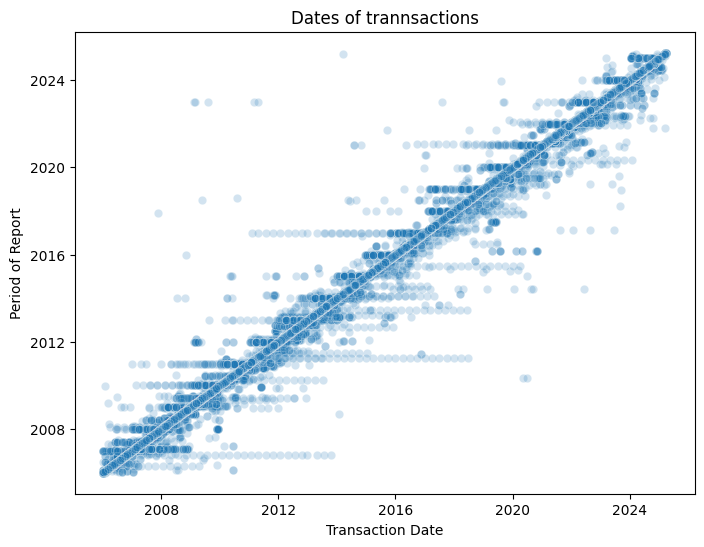

In [56]:
plt.figure(figsize=(8,6))
sns.scatterplot(data = filtered_date, x = 'Transaction Date', y = 'Period of Report', alpha =0.2)
plt.xlabel('Transaction Date')
plt.ylabel('Period of Report')
plt.title('Dates of trannsactions')
plt.show()

I think the next interesting thing to look at would be the average price on the transaction date and the average price paid for the transaction date.

In [57]:
filtered_date['avgprice_transdate'] = np.round((filtered_date['transactiondate_high'] + filtered_date['transactiondate_low'])/2,2)
min_price_per_share = filtered_date['average_price_per_share'].min()
max_price_per_share = filtered_date['average_price_per_share'].max()
print(f"Min price: {min_price_per_share}; Max price: {max_price_per_share}")

Min price: 0.0; Max price: 250000000.0


Okay, the first thing we need to do is drop all transactions where the average price per share is less than $5 because penny stocks are usually too volatile.

In [58]:
filtered_date = filtered_date[filtered_date['average_price_per_share']>5.0]
min_price_per_share = filtered_date['average_price_per_share'].min()
max_price_per_share = filtered_date['average_price_per_share'].max()
print(f"Min price: {min_price_per_share}; Max price: {max_price_per_share}")

Min price: 5.001538461538462; Max price: 250000000.0


Now, we need to address the higher end of the price data. It seems as though we have a few prices that are just way too high, in the order of hundereds of millions per share. We can easily catch these by looking at any stock price that is over $100,000 per share. First, let's take a look at the prices visually.

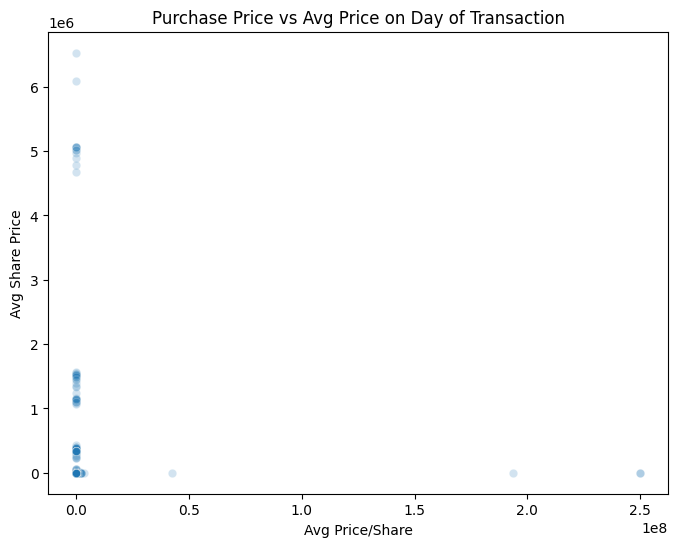

In [59]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=filtered_date, x = 'average_price_per_share', y = 'avgprice_transdate', alpha =0.2)
plt.xlabel('Avg Price/Share')
plt.ylabel('Avg Share Price')
plt.title('Purchase Price vs Avg Price on Day of Transaction')
plt.show()

Alright, this scatter plot is pretty striking. There is a lot of density around 0.0,0.0 which is to be expected when we have log scales on both axis. Clearly, it looks like some of these stock prices are wrong, as I doubt anyone is paying on the order of 250000000 for 1 share. Let's find the difference between these values and look at it on a histogram.

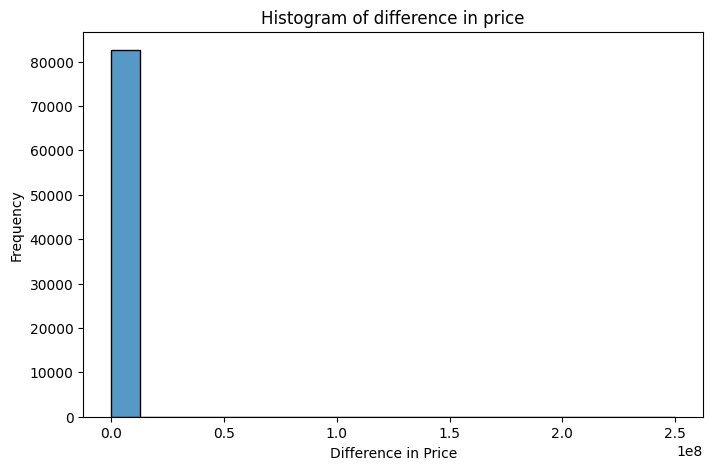

In [60]:
filtered_date['diff_purchase_price'] = (filtered_date['average_price_per_share']-filtered_date['avgprice_transdate']).abs()
plt.figure(figsize=(8,5))
sns.histplot(data = filtered_date, x = 'diff_purchase_price',bins=20)
plt.xlabel('Difference in Price')
plt.ylabel('Frequency')
plt.title('Histogram of difference in price')
plt.show()


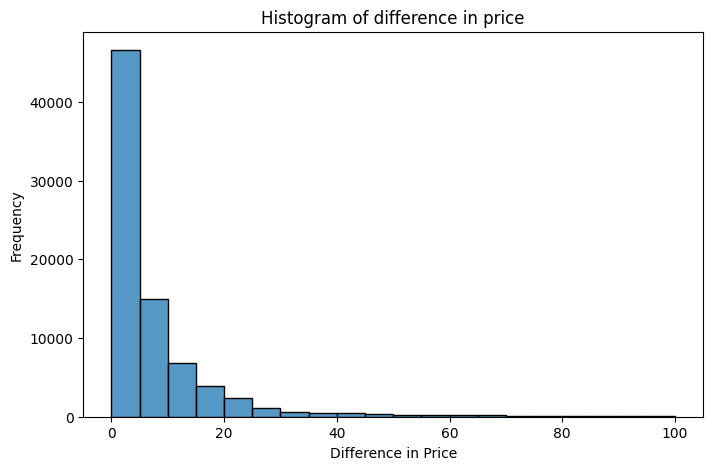

In [61]:
plt.figure(figsize = (8,5))
sns.histplot(data=filtered_date, x='diff_purchase_price',bins=20,binrange=(0,100))
plt.xlabel('Difference in Price')
plt.ylabel('Frequency')
plt.title('Histogram of difference in price')
plt.show()

So, it appears the vast majority (just under 80,000 transactions) fall within $10 of the average price on that date.

In [62]:
 filtered_date[filtered_date['average_price_per_share']==250000000].iloc[:,:15]

,Insider Name,Insider Title,Insider Role,Issuer,Ticker,CIK Code,Period of Report,Transaction Date,Security,Transaction Code,Ownership Type,ACCESSION_NUMBER,shares,price_per_share,shares_after
93000,ROSS WILBUR L JR,Missing,Tenpercentowner,ASSURED GUARANTY LTD,AGO,1273813,2008-02-28,2008-04-08,Common Stock,P,I,0001181431-08-024363,10651896.0,250000000.0,12166396.0
93001,ROSS WILBUR L JR,Missing,Tenpercentowner,ASSURED GUARANTY LTD,AGO,1273813,2008-02-28,2008-04-08,Common Stock,P,I,0001181431-08-030008,10651896.0,250000000.0,12166396.0


The cost of this stock is clearly wrong, let's see if this was an issue with my aggregation or if it was an issue in the original Form4 records.

In [63]:
#Read in the .csv file
orig_df = pd.read_csv('all_common_stock_purchases 2006 to 4Q24.csv')
print(f"Let's take a look at the size of our dataframe: {orig_df.shape}\n")
#print(cs_df.head())

ago_df = orig_df[orig_df['Ticker']=='AGO']
ago_df.shape
ago_df.iloc[:,7:13]

Let's take a look at the size of our dataframe: (463300, 15)



,Transaction Date,Security,Transaction Code,Shares,Price per Share,Shares After
22209,9-Aug-06,Common Stock,P,5000.0,2.489000e+01,12795.26
130010,8-Apr-08,Common Stock,P,10651896.0,2.500000e+08,12166396.00
133833,8-Apr-08,Common Stock,P,10651896.0,2.500000e+08,12166396.00
174765,24-Jun-09,Common Stock,P,3850000.0,4.235000e+07,16023984.00
228059,25-Aug-11,Common Stock,P,6690.0,1.195000e+01,17371186.00
228372,22-Aug-11,Common Stock,P,50000.0,1.133000e+01,16961996.00
228373,24-Aug-11,Common Stock,P,80000.0,1.188000e+01,17364496.00
228374,23-Aug-11,Common Stock,P,322500.0,1.161000e+01,17284496.00
228935,19-Aug-11,Common Stock,P,120000.0,1.153000e+01,16911996.00
228936,18-Aug-11,Common Stock,P,256000.0,1.160000e+01,16791996.00


So unfortunately, it looks like these are inaccurate reports of price per share it was actually around $25 a share, not 250000000. In Jun of 2009, the stock was still in the high teens low 20's so I have no idea where the 4.23e8 came from. We will just have to remove these.


In [64]:
filtered_date = filtered_date.drop(index = [93000,93001])
min_price_per_share = filtered_date['average_price_per_share'].min()
max_price_per_share = filtered_date['average_price_per_share'].max()
print(f"Min price: {min_price_per_share}; Max price: {max_price_per_share}")

Min price: 5.001538461538462; Max price: 193537611.0


Let's take a look at all of the stocks that have over $100,000 average price per share and after that we can narrow down the stocks that have a significant different between the average price on the date of transaction and the average price per share.

In [65]:
high_price_df = filtered_date[filtered_date['average_price_per_share']>100000]
indexes = list(high_price_df.index)
print(high_price_df.shape)
high_price_df[['Ticker','Transaction Date','average_price_per_share','avgprice_transdate','diff_purchase_price']].head()


(32, 66)


,Ticker,Transaction Date,average_price_per_share,avgprice_transdate,diff_purchase_price
3819,INVA,2010-04-30,143000.0,12.70,142987.30
6984,NXPL,2022-12-14,1899999.5,1.44,1899998.06
13073,PEFF,2006-11-30,300000.0,4.05,299995.95
13074,PEFF,2006-11-30,300000.0,4.05,299995.95
21066,NOEC,2010-09-28,938496.0,0.91,938495.09


A quick look at these prices on the date of transaction versus the average price per share clearly shows abnormal date. Let's grab these indexes and remove them from our dataframe.

In [66]:
filtered_date = filtered_date.drop(index = indexes)
min_price_per_share = filtered_date['average_price_per_share'].min()
max_price_per_share = filtered_date['average_price_per_share'].max()
print(f"Min price: {min_price_per_share}; Max price: {max_price_per_share}")
filtered_date.shape

Min price: 5.001538461538462; Max price: 95593.41130604288


(82565, 66)

Lets put in a quick session to see how many are above and below the high and low of the stock price meaning the shares were purchased at a price within the trading range of that day.


In [67]:
orig_len = (filtered_date.shape[0])
print(filtered_date.shape)
high_low_df = filtered_date[(filtered_date['average_price_per_share'] <= filtered_date['transactiondate_high'])&(filtered_date['average_price_per_share'] >= filtered_date['transactiondate_low'])].copy()
new_len = (high_low_df.shape[0])
print(high_low_df.shape)
print(f"There are only {np.round(new_len/orig_len*100,1)}% of transactions left")

(82565, 66)
(19975, 66)
There are only 24.2% of transactions left


That got rid of some of the extreme outliers but it appears as though we still have some significantly high prices. Let's address this by looking at any stocks that have an avg_price_per_share greater than $100 of the avg price on the transaction date.

In [68]:
diff_price_df = filtered_date[filtered_date['diff_purchase_price']>100].copy()
diff_price_df.shape

(3514, 66)

Okay, there is over 5000 records with greater than 100 difference in price. 100 different in a stock that is $2/share versus one that is $1000 per share is a big difference. So let's normalize this against it's avg price on the transaction date to see the percent different

In [69]:
diff_price_df['normalized_diff'] = diff_price_df['diff_purchase_price']/diff_price_df['avgprice_transdate'] * 100
#lets look for differences greater than 5%
new_diff_df = diff_price_df[diff_price_df['normalized_diff']>50]
new_diff_df.shape

(3511, 67)

Okay, it looks like they are all more than 5% different then the closing price on the date of the transaction. 99.9% of them are greater than 50%. I think it is safe to assume that we should remove all of these transactions as well. That also makes me wonder how many are more than certain percentages in our main dataframe?

In [83]:
filtered_date['normalized_diff'] = filtered_date['diff_purchase_price']/filtered_date['avgprice_transdate'] * 100
#lets look for differences greater than 25%
big_diff_df = filtered_date[filtered_date['normalized_diff']>25]
length_filt = big_diff_df.shape[0]
length_nofilt=filtered_date.shape[0]
print(length_nofilt, length_filt)
print(f"{np.round(length_filt/length_nofilt * 100,2)}% of records have more than 25% difference between the avg stock price on the date of the transaction and the average buy price provided")

82565 38685
46.85% of records have more than 25% difference between the avg stock price on the date of the transaction and the average buy price provided


So nearly 55,000 records have more than a 25% difference between avg stock price and price of the buy on the transaction date. That's pretty significant.

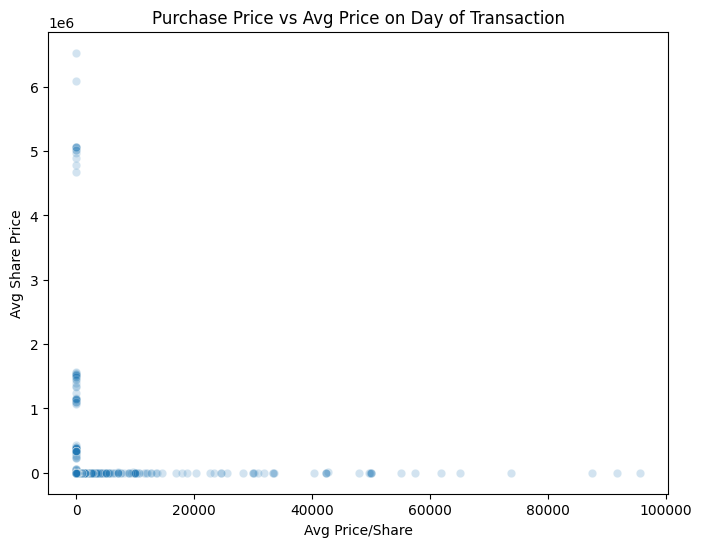

In [71]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=filtered_date, x = 'average_price_per_share', y = 'avgprice_transdate', alpha =0.2)
plt.xlabel('Avg Price/Share')
plt.ylabel('Avg Share Price')
plt.title('Purchase Price vs Avg Price on Day of Transaction')
plt.show()

Okay, this will dramatically reduce our dataset but let's take a look at what we might have for any stocks where its actually less than 5%.

In [72]:
low_diff_df = filtered_date[filtered_date['normalized_diff']<=5]
print(low_diff_df.shape)
print(len(low_diff_df['Insider Title'].unique()))
print(low_diff_df['Insider Title'].value_counts()[:10])

(24405, 67)
1135
Insider Title
Missing                     16046
Chief Executive Officer      1067
President and CEO             720
Chief Financial Officer       408
President & CEO               383
CEO                           257
Chairman and CEO              242
Executive Vice President      174
President and COO             169
President                     143
Name: count, dtype: int64


Okay, this dramatically reduces our data set but we still have a few hundered of each position which may be enough for an analysis. At least it is more likely to be an accurate analysis.

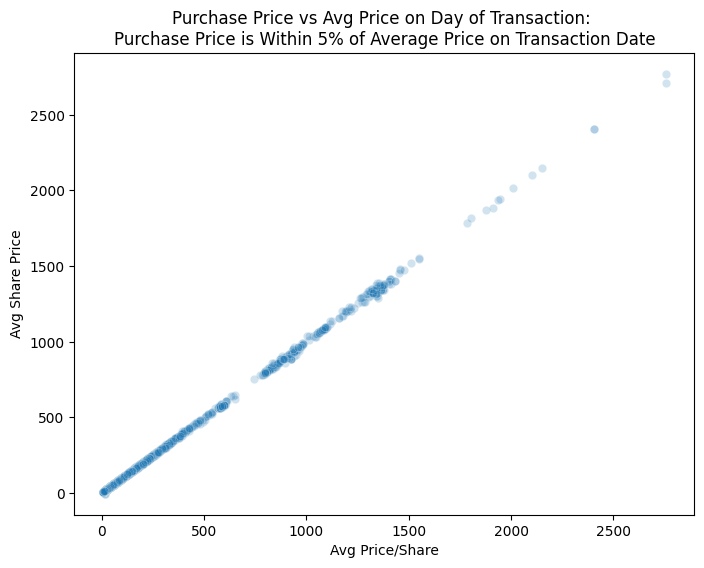

In [86]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=low_diff_df, x = 'average_price_per_share', y = 'avgprice_transdate', alpha =0.2)
plt.xlabel('Avg Price/Share')
plt.ylabel('Avg Share Price')
plt.title('Purchase Price vs Avg Price on Day of Transaction: \nPurchase Price is Within 5% of Average Price on Transaction Date')
plt.show()

If we were to use only the data that was within the high and low of the transaction date we would have. The following graph.

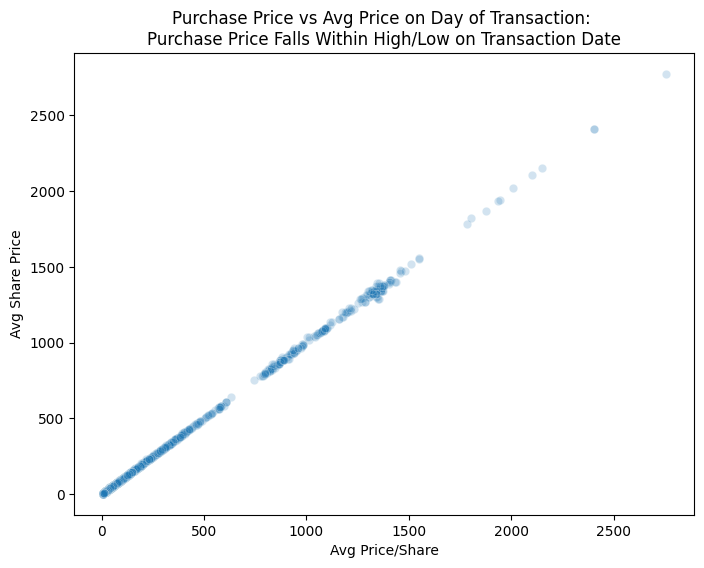

In [85]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=high_low_df, x = 'average_price_per_share', y = 'avgprice_transdate', alpha =0.2)
plt.xlabel('Avg Price/Share')
plt.ylabel('Avg Share Price')
plt.title('Purchase Price vs Avg Price on Day of Transaction: \nPurchase Price Falls Within High/Low on Transaction Date')
plt.show()

I think the next natural step is to try and clear up the Insider Role and titles. Let's first look and see how many of the 'missing titles' have director in the 'Insider Role' section. Let's start by working with the 'Insider Role' Column as there are much less data points and options there. It will work as a proof of concept for the Insider title column.

In [87]:
missing_title = high_low_df[high_low_df['Insider Title']=='Missing']
print(missing_title.shape)
#Let's now look at the unique roles we have in here.
roles = missing_title['Insider Role'].unique()
print(f"There are {len(roles)} different roles that we need to work with")
roles

(13136, 66)
There are 9 different roles that we need to work with


array(['Director', 'Tenpercentowner', 'Directorother',
       'Director,Tenpercentowner', 'Tenpercentownerother',
       'Director,Other', 'Director,Tenpercentowner,Other',
       'Director,Tenpercentownerother', 'Tenpercentowner,Other'],
      dtype=object)

Okay, the first thing we will need to do is split the inforamtion (most often by a comma) so we will address that first. We need to write a function that will split, rename, then rejoin. Then we can use dummies to easily filter the dataframes.

In [88]:
#Let's create a map for the roles to be replaced
role_mapping = {'Director':'Director',
                'Tenpercentowner':'10%owner',
                'Tenpercentownerother': '10%owner,Other',
                'Other':'Other',
                'Directorother':'Director,Other'}
mapped_role = missing_title.copy()
#Let's create a function that splits them changes them and rejoins them
def mapping_roles(roles):
    role = [r.strip() for r in roles.split(',')]
    map_roles = [role_mapping.get(r,r) for r in role]
    return ','.join(map_roles)

mapped_role['Mapped Roles'] = mapped_role['Insider Role'].apply(mapping_roles)
roles = mapped_role['Mapped Roles'].unique()
print(f"The new number of roles is {len(roles)}")
roles

The new number of roles is 6


array(['Director', '10%owner', 'Director,Other', 'Director,10%owner',
       '10%owner,Other', 'Director,10%owner,Other'], dtype=object)

Okay, now that we have cleaned this up, we can one hot encode this by using the get_dummies method.

In [89]:
role_dummies = mapped_role['Mapped Roles'].str.get_dummies(sep=',')
full_df = pd.concat([mapped_role,role_dummies],axis=1)
full_df.head()

,Insider Name,Insider Title,Insider Role,Issuer,Ticker,CIK Code,Period of Report,Transaction Date,Security,Transaction Code,...,transactiondate_high,transactiondate_low,reportdate_high,reportdate_low,avgprice_transdate,diff_purchase_price,Mapped Roles,10%owner,Director,Other
67,ABERCROMBIE GEORGE B,Missing,Director,BIOCRYST PHARMACEUTICALS INC,BCRX,882796,2013-11-12,2013-11-12,Common Stock,P,...,6.33,5.60,6.33,5.60,5.96,0.230,Director,0,1,0
75,ABERNATHY ROBERT E,Missing,Director,HAEMONETICS CORP,HAE,313143,2020-08-11,2020-08-11,Common Stock,P,...,81.15,78.99,81.15,78.99,80.07,0.860,Director,0,1,0
142,ABRAHAM CHAD R,Missing,Director,COLUMBUS MCKINNON CORP,CMCO,1005229,2025-03-03,2025-03-03,Common Stock,P,...,17.44,15.89,17.44,15.89,16.66,0.615,Director,0,1,0
154,ABRAHAMSON JAMES A,Missing,Director,"GeoEye, Inc.",GEOY,1040570,2011-12-01,2011-12-01,common stock,P,...,19.29,18.33,19.29,18.33,18.81,0.410,Director,0,1,0
162,ABRAMS DAVID C,Missing,Tenpercentowner,ASBURY AUTOMOTIVE GROUP INC,ABG,1144980,2020-03-18,2020-03-18,Common Stock,P,...,44.96,41.41,44.96,41.41,43.18,0.090,10%owner,1,0,0


Now, we can look at whoever we want based on the roles that they have. We can look at the average return of Directors by filtering the dataframe and then using a scatter plot.

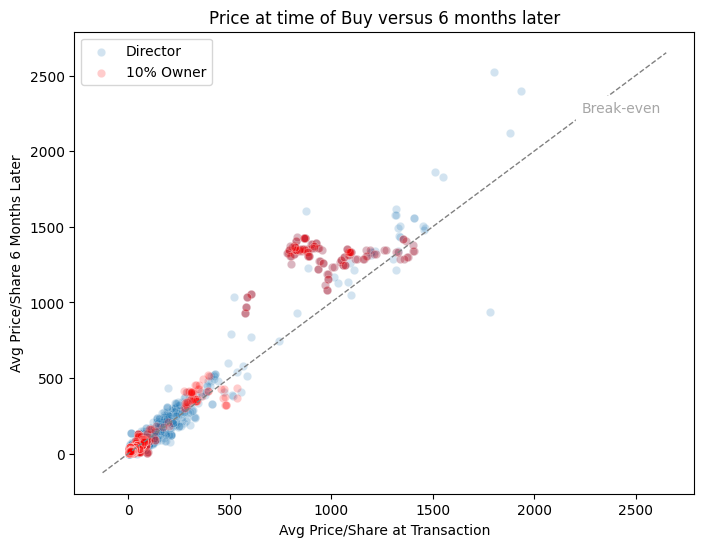

In [90]:
#Let's Look at Directors vs. 10% Owners
dir_df = full_df[full_df['Director']==1]
own_df = full_df[full_df['10%owner']==1]
plt.figure(figsize=(8,6))
sns.scatterplot(data=dir_df, x = 'average_price_per_share', y = 'price_6month', alpha =0.2,label='Director')
sns.scatterplot(data=own_df, x = 'average_price_per_share',y='price_6month',alpha=0.2,color='red',label='10% Owner')

#Let's put in a 45degree line to show break even
ax = plt.gca()
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
plt.plot(lims, lims, linestyle='--', color='gray', linewidth=1)

#Lets give it an annotation
x_text = lims[0] + 0.85 * (lims[1] - lims[0])
y_text = x_text
plt.text(
    x_text, y_text,
    'Break-even',
    ha='left', va='bottom',
    fontsize=10,
    color='gray',
    backgroundcolor='white',
    alpha=0.7
)

plt.xlabel('Avg Price/Share at Transaction')
plt.ylabel('Avg Price/Share 6 Months Later')
plt.title('Price at time of Buy versus 6 months later')
plt.show()

We now need to apply this to our large dataframe as this was only a small proof of concept.

In [93]:
#Let's now look at the unique roles we have in here.
roles = high_low_df['Insider Role'].unique()
print(f"There are {len(roles)} different roles that we need to work with")
roles

There are 18 different roles that we need to work with


array(['Officer', 'Director', 'Tenpercentowner', 'Director,Officer',
       'Directorother', 'Director,Officer,Tenpercentowner',
       'Director,Tenpercentowner', 'Tenpercentownerother',
       'Director,Other', 'Director,Tenpercentowner,Other',
       'Director,Officerother', 'Officerother',
       'Director,Tenpercentownerother',
       'Director,Officer,Tenpercentowner,Other',
       'Director,Officer,Tenpercentownerother', 'Officer,Tenpercentowner',
       'Tenpercentowner,Other', 'Director,Officer,Other'], dtype=object)

In [94]:
print(f"Shape of our df originally: {high_low_df.shape}")
role_mapped = high_low_df.copy()
role_mapping = {'Director':'Director',
                'Tenpercentowner':'10%owner',
                'Officer':'Officer',
                'Other':'Other',
                'Director,Officer,Tenpercentownerother':'Director,Officer,10%owner,Other',
                'Director,Officerother':'Director,Officer,Other',
                'Director,Tenpercentownerother':'Director,10%owner,Other',
                'Tenpercentownerother': '10%owner,Other',
                'Officerother':'Officer,Other',
                'Directorother':'Director,Other'}
#Let's create a function that splits them changes them and rejoins them
def mapping_roles(roles):
    role = [r.strip() for r in roles.split(',')]
    map_roles = [role_mapping.get(r,r) for r in role]
    return ','.join(map_roles)

role_mapped['Mapped Roles'] = role_mapped['Insider Role'].apply(mapping_roles)
roles = role_mapped['Mapped Roles'].unique()
print(f"Now the shape is {role_mapped.shape}")
print(f"The new number of roles is {len(roles)}")
roles

Shape of our df originally: (19975, 66)
Now the shape is (19975, 67)
The new number of roles is 13


array(['Officer', 'Director', '10%owner', 'Director,Officer',
       'Director,Other', 'Director,Officer,10%owner', 'Director,10%owner',
       '10%owner,Other', 'Director,10%owner,Other',
       'Director,Officer,Other', 'Officer,Other',
       'Director,Officer,10%owner,Other', 'Officer,10%owner'],
      dtype=object)

In [95]:
#Excellent, let's one hot encode
role_dummies = role_mapped['Mapped Roles'].str.get_dummies(sep=',')
role_dummies = pd.concat([role_mapped,role_dummies],axis=1)
print(role_dummies.shape)
role_dummies.head()

(19975, 71)


,Insider Name,Insider Title,Insider Role,Issuer,Ticker,CIK Code,Period of Report,Transaction Date,Security,Transaction Code,...,transactiondate_low,reportdate_high,reportdate_low,avgprice_transdate,diff_purchase_price,Mapped Roles,10%owner,Director,Officer,Other
64,ABENDSCHEIN ROBERT D.,See Remarks,Officer,TALOS ENERGY INC.,TALO,1724965,2020-08-11,2020-08-11,Common Stock,P,...,7.98,8.68,7.98,8.33,0.01,Officer,0,0,1,0
65,ABENDSCHEIN ROBERT D.,See Remarks,Officer,TALOS ENERGY INC.,TALO,1724965,2021-11-19,2021-11-19,Common Stock,P,...,9.47,9.97,9.47,9.72,0.02,Officer,0,0,1,0
66,ABENDSCHEIN ROBERT D.,See Remarks,Officer,TALOS ENERGY INC.,TALO,1724965,2021-11-19,2021-11-19,Common Stock,P,...,9.47,9.97,9.47,9.72,0.02,Officer,0,0,1,0
67,ABERCROMBIE GEORGE B,Missing,Director,BIOCRYST PHARMACEUTICALS INC,BCRX,882796,2013-11-12,2013-11-12,Common Stock,P,...,5.60,6.33,5.60,5.96,0.23,Director,0,1,0,0
75,ABERNATHY ROBERT E,Missing,Director,HAEMONETICS CORP,HAE,313143,2020-08-11,2020-08-11,Common Stock,P,...,78.99,81.15,78.99,80.07,0.86,Director,0,1,0,0


We have now had the proof of concept for the smaller 'Insider Role' Column. Now we have to deal with the really large 'Insider Title' Column. This is a much larger number of roles that we will have to deal with, so we will use a similar function to the one we used before. This is going to likely take many repetitions in order to get every title that we need to do. So let's start by looking at the value counts and working our way through them.

In [96]:
full_df = role_dummies.copy()
full_df['Insider Title'].value_counts()

,count
Insider Title,
Missing,13136
Chief Executive Officer,995
President and CEO,635
Chief Financial Officer,351
President & CEO,310
...,...
"SVP, Chief Business Officer",1
"VP, Development and Research",1
"Grp Exec, Intl & Corp Dev",1
